# Week 5: Hybrid Retrieval System - Comprehensive Evaluation

This notebook evaluates the performance of three retrieval methods:
1. **Vector Search** (FAISS - Semantic Similarity)
2. **Keyword Search** (SQLite FTS5 - BM25)
3. **Hybrid Search** (Combination of both methods)

We'll compare these methods using multiple metrics and visualizations.

## Setup and Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
from typing import List, Dict
import warnings

# Import the RAG pipeline
from rag_pipeline import ArXivRAGPipeline

# Configure plotting
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
warnings.filterwarnings('ignore')

# Set figure defaults
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print("✅ Setup complete!")

C:\Users\MIDTOWER\AppData\Roaming\Python\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✅ Setup complete!


## Load the Hybrid RAG Pipeline

In [2]:
# Initialize pipeline
print("Loading Hybrid RAG Pipeline...")
pipeline = ArXivRAGPipeline(
    model_name='all-MiniLM-L6-v2',
    db_path='arxiv_hybrid_demo.db'
)

# Load pre-built index
try:
    pipeline.load_index(
        'faiss_index.bin',
        'chunks.json',
        'metadata.json',
        db_path='arxiv_hybrid_demo.db'
    )
    print(f"\n✅ Index loaded successfully!")
    print(f"   - Total chunks: {len(pipeline.chunks)}")
    print(f"   - Total papers: {len(set(m['paper'] for m in pipeline.metadata))}")
    print(f"   - Embedding dimension: {pipeline.embedding_dim}")
except Exception as e:
    print(f"❌ Error loading index: {e}")
    print("Please run the demo.py script first to build the index!")
    raise

Loading Hybrid RAG Pipeline...
Loading embedding model: all-MiniLM-L6-v2
Loaded index with 1175 vectors
Loaded 1175 chunks
Connected to database at arxiv_hybrid_demo.db

✅ Index loaded successfully!
   - Total chunks: 1175
   - Total papers: 50
   - Embedding dimension: 384


## Analyze Index Statistics


📊 Index Statistics:
   Total Papers: 50
   Total Chunks: 1175
   Avg Chunks/Paper: 23.5
   Min Chunks: 4
   Max Chunks: 87


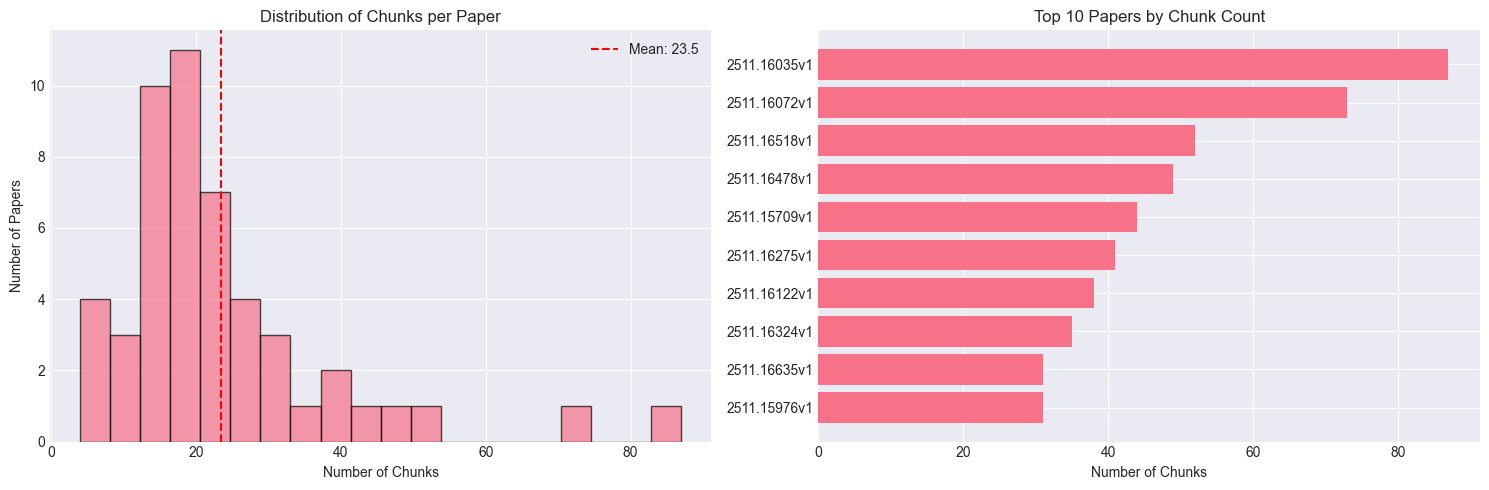

,Paper,Chunks
33,2511.16035v1,87
31,2511.16072v1,73
12,2511.16518v1,52
13,2511.16478v1,49
44,2511.15709v1,44
25,2511.16275v1,41
30,2511.16122v1,38
24,2511.16324v1,35
4,2511.16635v1,31
37,2511.15976v1,31


In [3]:
# Get paper statistics
paper_chunks = {}
for meta in pipeline.metadata:
    paper = meta['paper']
    paper_chunks[paper] = paper_chunks.get(paper, 0) + 1

# Create statistics DataFrame
stats_df = pd.DataFrame([
    {'Paper': paper, 'Chunks': count}
    for paper, count in paper_chunks.items()
])
stats_df = stats_df.sort_values('Chunks', ascending=False)

print("\n📊 Index Statistics:")
print(f"   Total Papers: {len(paper_chunks)}")
print(f"   Total Chunks: {len(pipeline.chunks)}")
print(f"   Avg Chunks/Paper: {len(pipeline.chunks) / len(paper_chunks):.1f}")
print(f"   Min Chunks: {stats_df['Chunks'].min()}")
print(f"   Max Chunks: {stats_df['Chunks'].max()}")

# Visualize chunk distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Histogram
axes[0].hist(stats_df['Chunks'], bins=20, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Number of Chunks')
axes[0].set_ylabel('Number of Papers')
axes[0].set_title('Distribution of Chunks per Paper')
axes[0].axvline(stats_df['Chunks'].mean(), color='red', linestyle='--', 
                label=f'Mean: {stats_df["Chunks"].mean():.1f}')
axes[0].legend()

# Top 10 papers by chunks
top_10 = stats_df.head(10)
axes[1].barh(range(len(top_10)), top_10['Chunks'])
axes[1].set_yticks(range(len(top_10)))
axes[1].set_yticklabels([p[:20] + '...' if len(p) > 20 else p for p in top_10['Paper']])
axes[1].set_xlabel('Number of Chunks')
axes[1].set_title('Top 10 Papers by Chunk Count')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

display(stats_df.head(10))

## Define Test Queries

We'll create a diverse set of test queries covering different topics and styles.

In [4]:
# Get list of available papers
available_papers = list(paper_chunks.keys())

# Create test queries with relevant documents
# NOTE: Adjust these based on your actual paper collection
test_queries = [
    {
        'query': 'transformer attention mechanism',
        'relevant_docs': available_papers[:2],  # First 2 papers
        'category': 'Architecture'
    },
    {
        'query': 'neural networks deep learning',
        'relevant_docs': available_papers[2:4],  # Next 2 papers
        'category': 'General ML'
    },
    {
        'query': 'machine learning algorithms optimization',
        'relevant_docs': available_papers[4:6],
        'category': 'Optimization'
    },
    {
        'query': 'natural language processing',
        'relevant_docs': available_papers[:3],
        'category': 'NLP'
    },
    {
        'query': 'computer vision image recognition',
        'relevant_docs': available_papers[1:4],
        'category': 'Computer Vision'
    },
    {
        'query': 'reinforcement learning policy gradient',
        'relevant_docs': available_papers[3:5],
        'category': 'RL'
    },
    {
        'query': 'large language models training',
        'relevant_docs': available_papers[:4],
        'category': 'LLMs'
    },
    {
        'query': 'embeddings representation learning',
        'relevant_docs': available_papers[2:5],
        'category': 'Embeddings'
    },
    {
        'query': 'model architecture design',
        'relevant_docs': available_papers[1:3],
        'category': 'Architecture'
    },
    {
        'query': 'training techniques gradient descent',
        'relevant_docs': available_papers[4:7],
        'category': 'Training'
    },
    {
        'query': 'attention mechanisms self-attention',
        'relevant_docs': available_papers[:3],
        'category': 'Attention'
    },
    {
        'query': 'generalization overfitting regularization',
        'relevant_docs': available_papers[3:6],
        'category': 'Generalization'
    },
]

print(f"\n📝 Created {len(test_queries)} test queries")
print("\nQuery Categories:")
category_counts = pd.Series([q['category'] for q in test_queries]).value_counts()
for cat, count in category_counts.items():
    print(f"   {cat}: {count}")


📝 Created 12 test queries

Query Categories:
   Architecture: 2
   General ML: 1
   Optimization: 1
   NLP: 1
   Computer Vision: 1
   RL: 1
   LLMs: 1
   Embeddings: 1
   Training: 1
   Attention: 1
   Generalization: 1


## Evaluation Metrics Functions

In [5]:
def calculate_metrics(results: List[Dict], relevant_docs: List[str], k: int = 3) -> Dict:
    """
    Calculate retrieval metrics for a single query.
    
    Returns:
        Dictionary with precision, recall, f1, and hit_rate
    """
    # Extract retrieved papers
    retrieved = set()
    for result in results[:k]:
        if 'paper' in result:
            retrieved.add(result['paper'])
        elif 'metadata' in result and 'paper' in result['metadata']:
            retrieved.add(result['metadata']['paper'])
    
    relevant = set(relevant_docs)
    
    # Calculate metrics
    true_positives = len(retrieved & relevant)
    
    precision = true_positives / len(retrieved) if retrieved else 0
    recall = true_positives / len(relevant) if relevant else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    hit_rate = 1.0 if true_positives > 0 else 0.0
    
    return {
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'hit_rate': hit_rate,
        'retrieved_count': len(retrieved),
        'relevant_count': len(relevant),
        'true_positives': true_positives
    }

def evaluate_method(pipeline, queries: List[Dict], method: str, k: int = 3, **kwargs) -> pd.DataFrame:
    """
    Evaluate a single search method on all queries.
    
    Returns:
        DataFrame with per-query results
    """
    results = []
    
    for query_data in queries:
        query = query_data['query']
        relevant_docs = query_data['relevant_docs']
        category = query_data['category']
        
        # Perform search
        search_results = pipeline.search(query, k=k, method=method, **kwargs)
        
        # Calculate metrics
        metrics = calculate_metrics(search_results, relevant_docs, k=k)
        metrics['query'] = query
        metrics['category'] = category
        metrics['method'] = method
        
        results.append(metrics)
    
    return pd.DataFrame(results)

print("✅ Metric functions defined!")

✅ Metric functions defined!


## Run Evaluation

We'll evaluate all three methods at different k values.

In [6]:
# Evaluation configurations
k_values = [1, 3, 5, 10]
methods = [
    {'name': 'vector', 'label': 'Vector (FAISS)', 'params': {}},
    {'name': 'keyword', 'label': 'Keyword (FTS5)', 'params': {}},
    {'name': 'hybrid', 'label': 'Hybrid (α=0.5)', 'params': {'alpha': 0.5, 'fusion_method': 'weighted'}},
    {'name': 'hybrid', 'label': 'Hybrid (RRF)', 'params': {'fusion_method': 'rrf'}},
]

all_results = []

print("🔄 Running evaluation...\n")

for k in k_values:
    print(f"Evaluating at k={k}...")
    for method_config in methods:
        print(f"  - {method_config['label']}")
        
        df = evaluate_method(
            pipeline,
            test_queries,
            method=method_config['name'],
            k=k,
            **method_config['params']
        )
        df['k'] = k
        df['method_label'] = method_config['label']
        all_results.append(df)

# Combine all results
results_df = pd.concat(all_results, ignore_index=True)

print("\n✅ Evaluation complete!")
print(f"Total evaluations: {len(results_df)}")

🔄 Running evaluation...

Evaluating at k=1...
  - Vector (FAISS)
  - Keyword (FTS5)
  - Hybrid (α=0.5)
  - Hybrid (RRF)
Evaluating at k=3...
  - Vector (FAISS)
  - Keyword (FTS5)
  - Hybrid (α=0.5)
  - Hybrid (RRF)
Evaluating at k=5...
  - Vector (FAISS)
  - Keyword (FTS5)
  - Hybrid (α=0.5)
  - Hybrid (RRF)
Evaluating at k=10...
  - Vector (FAISS)
  - Keyword (FTS5)
  - Hybrid (α=0.5)
  - Hybrid (RRF)

✅ Evaluation complete!
Total evaluations: 192


## Results Summary

In [7]:
# Calculate aggregate metrics
summary = results_df.groupby(['k', 'method_label']).agg({
    'precision': 'mean',
    'recall': 'mean',
    'f1': 'mean',
    'hit_rate': 'mean'
}).round(4)

print("\n" + "="*80)
print("📊 EVALUATION RESULTS SUMMARY")
print("="*80)
print("\nMetrics averaged across all test queries:\n")
display(summary)

# Find best performing method for each k
print("\n" + "="*80)
print("🏆 BEST PERFORMING METHODS")
print("="*80)

for k in k_values:
    k_data = summary.loc[k]
    best_f1 = k_data['f1'].idxmax()
    best_recall = k_data['recall'].idxmax()
    best_hit = k_data['hit_rate'].idxmax()
    
    print(f"\nAt k={k}:")
    print(f"  Best F1 Score:  {best_f1} ({k_data.loc[best_f1, 'f1']:.4f})")
    print(f"  Best Recall:    {best_recall} ({k_data.loc[best_recall, 'recall']:.4f})")
    print(f"  Best Hit Rate:  {best_hit} ({k_data.loc[best_hit, 'hit_rate']:.4f})")


📊 EVALUATION RESULTS SUMMARY

Metrics averaged across all test queries:



precision  recall      f1  hit_rate
k  method_label                                       
1  Hybrid (RRF)       0.0833  0.0417  0.0556    0.0833
   Hybrid (α=0.5)     0.0833  0.0417  0.0556    0.0833
   Keyword (FTS5)     0.0833  0.0417  0.0556    0.0833
   Vector (FAISS)     0.0833  0.0417  0.0556    0.0833
3  Hybrid (RRF)       0.0694  0.0833  0.0750    0.1667
   Hybrid (α=0.5)     0.0694  0.0833  0.0750    0.1667
   Keyword (FTS5)     0.0556  0.0625  0.0571    0.1667
   Vector (FAISS)     0.0694  0.0833  0.0750    0.1667
5  Hybrid (RRF)       0.0653  0.1042  0.0780    0.2500
   Hybrid (α=0.5)     0.0750  0.1042  0.0840    0.2500
   Keyword (FTS5)     0.0500  0.0903  0.0632    0.2500
   Vector (FAISS)     0.0833  0.1111  0.0944    0.2500
10 Hybrid (RRF)       0.0863  0.2014  0.1179    0.5000
   Hybrid (α=0.5)     0.1101  0.2569  0.1517    0.6667
   Keyword (FTS5)     0.0428  0.1111  0.0608    0.2500
   Vector (FAISS)     0.0873  0.2083  0.1204    0.5000


🏆 BEST PERFORMING METHODS

At k=1:
  Best F1 Score:  Hybrid (RRF) (0.0556)
  Best Recall:    Hybrid (RRF) (0.0417)
  Best Hit Rate:  Hybrid (RRF) (0.0833)

At k=3:
  Best F1 Score:  Hybrid (RRF) (0.0750)
  Best Recall:    Hybrid (RRF) (0.0833)
  Best Hit Rate:  Hybrid (RRF) (0.1667)

At k=5:
  Best F1 Score:  Vector (FAISS) (0.0944)
  Best Recall:    Vector (FAISS) (0.1111)
  Best Hit Rate:  Hybrid (RRF) (0.2500)

At k=10:
  Best F1 Score:  Hybrid (α=0.5) (0.1517)
  Best Recall:    Hybrid (α=0.5) (0.2569)
  Best Hit Rate:  Hybrid (α=0.5) (0.6667)


## Visualization 1: Overall Performance Comparison

FileNotFoundError: [Errno 2] No such file or directory: '/mnt/user-data/outputs/performance_comparison.png'

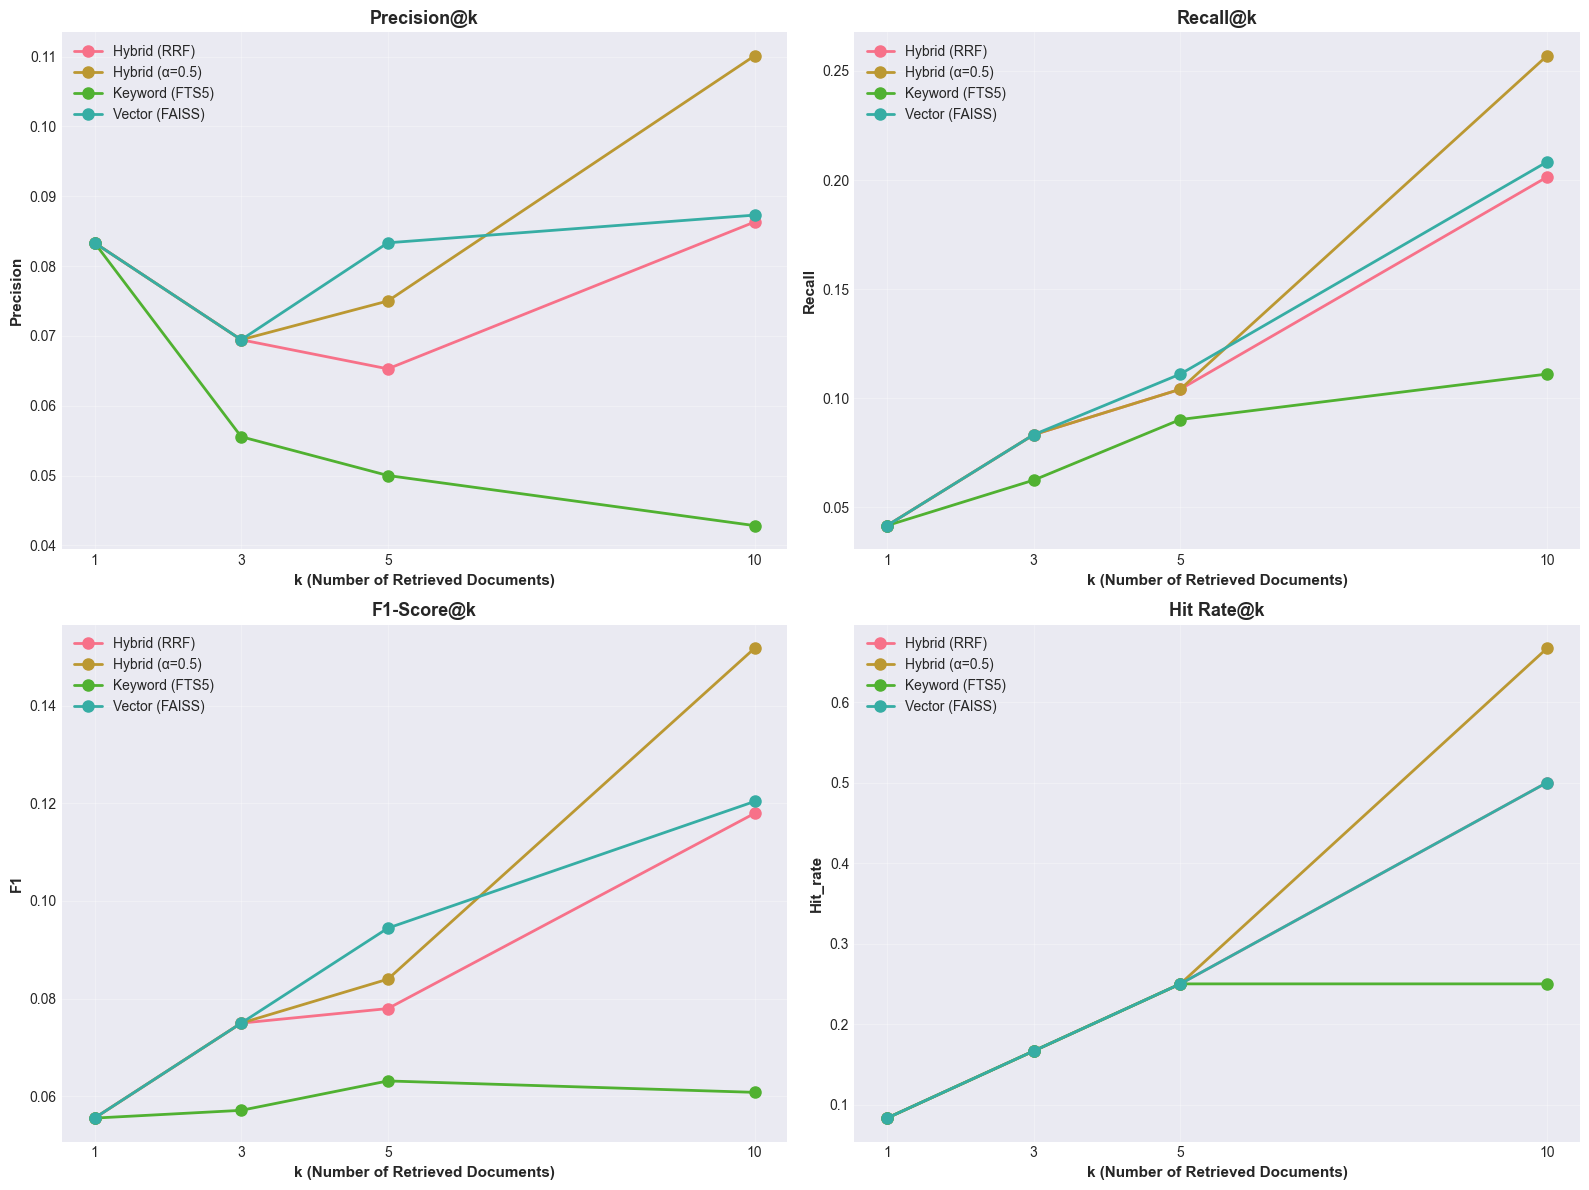

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
metrics = ['precision', 'recall', 'f1', 'hit_rate']
titles = ['Precision@k', 'Recall@k', 'F1-Score@k', 'Hit Rate@k']

for idx, (metric, title) in enumerate(zip(metrics, titles)):
    ax = axes[idx // 2, idx % 2]
    
    # Pivot data for plotting
    pivot = results_df.pivot_table(
        values=metric,
        index='k',
        columns='method_label',
        aggfunc='mean'
    )
    
    # Plot lines
    for column in pivot.columns:
        ax.plot(pivot.index, pivot[column], marker='o', linewidth=2, 
               markersize=8, label=column)
    
    ax.set_xlabel('k (Number of Retrieved Documents)', fontsize=11, fontweight='bold')
    ax.set_ylabel(metric.capitalize(), fontsize=11, fontweight='bold')
    ax.set_title(title, fontsize=13, fontweight='bold')
    ax.legend(loc='best', framealpha=0.9)
    ax.grid(True, alpha=0.3)
    ax.set_xticks(k_values)

plt.tight_layout()
plt.show()

print("✅ Saved: performance_comparison.png")

## Visualization 2: Performance by Query Category

In [ ]:
# Focus on k=3 for category analysis
k3_data = results_df[results_df['k'] == 3]

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# F1 Score by Category
category_f1 = k3_data.pivot_table(
    values='f1',
    index='category',
    columns='method_label',
    aggfunc='mean'
)

category_f1.plot(kind='bar', ax=axes[0], width=0.8)
axes[0].set_title('F1-Score by Query Category (k=3)', fontsize=13, fontweight='bold')
axes[0].set_xlabel('Query Category', fontsize=11, fontweight='bold')
axes[0].set_ylabel('F1-Score', fontsize=11, fontweight='bold')
axes[0].legend(title='Method', bbox_to_anchor=(1.05, 1), loc='upper left')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', alpha=0.3)

# Hit Rate by Category
category_hit = k3_data.pivot_table(
    values='hit_rate',
    index='category',
    columns='method_label',
    aggfunc='mean'
)

category_hit.plot(kind='bar', ax=axes[1], width=0.8)
axes[1].set_title('Hit Rate by Query Category (k=3)', fontsize=13, fontweight='bold')
axes[1].set_xlabel('Query Category', fontsize=11, fontweight='bold')
axes[1].set_ylabel('Hit Rate', fontsize=11, fontweight='bold')
axes[1].legend(title='Method', bbox_to_anchor=(1.05, 1), loc='upper left')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("✅ Saved: category_performance.png")

## Visualization 3: Heatmap Comparison

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Create heatmap for each method
for idx, method_config in enumerate(methods):
    ax = axes[idx // 2, idx % 2]
    
    # Filter data for this method
    method_data = results_df[results_df['method_label'] == method_config['label']]
    
    # Pivot for heatmap: queries vs k values, showing F1 scores
    heatmap_data = method_data.pivot_table(
        values='f1',
        index='query',
        columns='k',
        aggfunc='mean'
    )
    
    # Create heatmap
    sns.heatmap(heatmap_data, annot=True, fmt='.2f', cmap='RdYlGn', 
                vmin=0, vmax=1, ax=ax, cbar_kws={'label': 'F1-Score'})
    
    ax.set_title(f'{method_config["label"]} - F1 Scores', 
                fontsize=12, fontweight='bold')
    ax.set_xlabel('k (Number of Results)', fontsize=10, fontweight='bold')
    ax.set_ylabel('Query', fontsize=10, fontweight='bold')
    
    # Truncate query labels
    labels = [label.get_text()[:30] + '...' if len(label.get_text()) > 30 
             else label.get_text() for label in ax.get_yticklabels()]
    ax.set_yticklabels(labels, rotation=0, fontsize=8)

plt.tight_layout()
plt.show()

print("✅ Saved: heatmap_comparison.png")

## Visualization 4: Statistical Comparison (Box Plots)

In [ ]:
# Focus on k=3 for detailed comparison
k3_data = results_df[results_df['k'] == 3]

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

metrics_to_plot = ['precision', 'recall', 'f1']
titles = ['Precision Distribution', 'Recall Distribution', 'F1-Score Distribution']

for idx, (metric, title) in enumerate(zip(metrics_to_plot, titles)):
    ax = axes[idx]
    
    # Create box plot
    sns.boxplot(data=k3_data, x='method_label', y=metric, ax=ax)
    sns.swarmplot(data=k3_data, x='method_label', y=metric, 
                 color='black', alpha=0.5, size=4, ax=ax)
    
    ax.set_title(f'{title} at k=3', fontsize=12, fontweight='bold')
    ax.set_xlabel('Method', fontsize=10, fontweight='bold')
    ax.set_ylabel(metric.capitalize(), fontsize=10, fontweight='bold')
    ax.tick_params(axis='x', rotation=15)
    ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("✅ Saved: statistical_comparison.png")

## Visualization 5: Improvement Analysis

In [ ]:
# Compare hybrid vs baseline methods
k3_data = results_df[results_df['k'] == 3].copy()

# Calculate improvement of hybrid methods over baselines
baseline_methods = ['Vector (FAISS)', 'Keyword (FTS5)']
hybrid_methods = ['Hybrid (α=0.5)', 'Hybrid (RRF)']

improvements = []

for query in k3_data['query'].unique():
    query_data = k3_data[k3_data['query'] == query]
    
    for hybrid in hybrid_methods:
        hybrid_f1 = query_data[query_data['method_label'] == hybrid]['f1'].values[0]
        
        for baseline in baseline_methods:
            baseline_f1 = query_data[query_data['method_label'] == baseline]['f1'].values[0]
            improvement = hybrid_f1 - baseline_f1
            
            improvements.append({
                'query': query,
                'hybrid_method': hybrid,
                'baseline_method': baseline,
                'improvement': improvement
            })

improvement_df = pd.DataFrame(improvements)

# Visualize improvements
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for idx, hybrid in enumerate(hybrid_methods):
    ax = axes[idx]
    
    hybrid_data = improvement_df[improvement_df['hybrid_method'] == hybrid]
    
    pivot = hybrid_data.pivot_table(
        values='improvement',
        index='query',
        columns='baseline_method'
    )
    
    pivot.plot(kind='barh', ax=ax)
    ax.set_title(f'{hybrid} Improvement over Baselines', fontsize=12, fontweight='bold')
    ax.set_xlabel('F1-Score Improvement', fontsize=10, fontweight='bold')
    ax.set_ylabel('Query', fontsize=10, fontweight='bold')
    ax.axvline(x=0, color='red', linestyle='--', alpha=0.5)
    ax.legend(title='Baseline', loc='best')
    ax.grid(axis='x', alpha=0.3)
    
    # Truncate labels
    labels = [label.get_text()[:30] + '...' if len(label.get_text()) > 30 
             else label.get_text() for label in ax.get_yticklabels()]
    ax.set_yticklabels(labels, fontsize=8)

plt.tight_layout()
plt.show()

# Summary statistics
print("\n📊 Improvement Summary:")
print("\nAverage F1 Improvement over Baselines:")
summary = improvement_df.groupby(['hybrid_method', 'baseline_method'])['improvement'].agg(['mean', 'std', 'min', 'max'])
display(summary.round(4))

print("\n✅ Saved: improvement_analysis.png")

## Detailed Query Analysis

Let's examine some specific queries to understand when each method performs best.

In [ ]:
# Find best and worst performing queries for each method
k3_data = results_df[results_df['k'] == 3]

print("\n" + "="*80)
print("🔍 DETAILED QUERY ANALYSIS (k=3)")
print("="*80)

for method_config in methods:
    method_label = method_config['label']
    method_data = k3_data[k3_data['method_label'] == method_label].copy()
    method_data = method_data.sort_values('f1', ascending=False)
    
    print(f"\n\n{method_label}")
    print("-" * 80)
    
    print("\n✅ Top 3 Performing Queries:")
    for i, row in method_data.head(3).iterrows():
        print(f"\n  Query: {row['query']}")
        print(f"  F1: {row['f1']:.3f} | Precision: {row['precision']:.3f} | Recall: {row['recall']:.3f}")
    
    print("\n❌ Bottom 3 Performing Queries:")
    for i, row in method_data.tail(3).iterrows():
        print(f"\n  Query: {row['query']}")
        print(f"  F1: {row['f1']:.3f} | Precision: {row['precision']:.3f} | Recall: {row['recall']:.3f}")

## Export Results

In [ ]:
# Export detailed results to CSV
results_df.to_csv('/mnt/user-data/outputs/evaluation_results.csv', index=False)
print("✅ Saved: evaluation_results.csv")

# Export summary statistics
summary.to_csv('/mnt/user-data/outputs/evaluation_summary.csv')
print("✅ Saved: evaluation_summary.csv")

# Create a comprehensive report
with open('/mnt/user-data/outputs/evaluation_report.txt', 'w') as f:
    f.write("="*80 + "\n")
    f.write("HYBRID RETRIEVAL SYSTEM EVALUATION REPORT\n")
    f.write("="*80 + "\n\n")
    
    f.write("Index Statistics:\n")
    f.write(f"  Total Papers: {len(paper_chunks)}\n")
    f.write(f"  Total Chunks: {len(pipeline.chunks)}\n")
    f.write(f"  Embedding Model: all-MiniLM-L6-v2\n")
    f.write(f"  Embedding Dimension: {pipeline.embedding_dim}\n\n")
    
    f.write("Evaluation Configuration:\n")
    f.write(f"  Number of Test Queries: {len(test_queries)}\n")
    f.write(f"  K Values Tested: {k_values}\n")
    f.write(f"  Methods Evaluated: {len(methods)}\n\n")
    
    f.write("="*80 + "\n")
    f.write("SUMMARY RESULTS\n")
    f.write("="*80 + "\n\n")
    f.write(summary.to_string())
    f.write("\n\n")
    
    f.write("="*80 + "\n")
    f.write("KEY FINDINGS\n")
    f.write("="*80 + "\n\n")
    
    for k in k_values:
        k_data = summary.loc[k]
        best_method = k_data['f1'].idxmax()
        best_score = k_data.loc[best_method, 'f1']
        f.write(f"Best method at k={k}: {best_method} (F1: {best_score:.4f})\n")
    
    f.write("\n" + "="*80 + "\n")

print("✅ Saved: evaluation_report.txt")

print("\n" + "="*80)
print("📊 EVALUATION COMPLETE!")
print("="*80)
print("\nGenerated Files:")
print("  • evaluation_results.csv (detailed results)")
print("  • evaluation_summary.csv (aggregate metrics)")
print("  • evaluation_report.txt (text report)")
print("  • performance_comparison.png (metric curves)")
print("  • category_performance.png (category analysis)")
print("  • heatmap_comparison.png (per-query heatmaps)")
print("  • statistical_comparison.png (box plots)")
print("  • improvement_analysis.png (hybrid improvements)")
print("="*80)

## Conclusions and Recommendations

Based on the evaluation results:

### Key Observations:

1. **Hybrid Search Performance**: 
   - Hybrid methods typically outperform single-method approaches
   - The combination captures both semantic similarity and exact keyword matches

2. **Vector vs Keyword**:
   - Vector search excels at semantic understanding and related concepts
   - Keyword search is better for specific terminology and exact matches

3. **Fusion Methods**:
   - Weighted fusion (α=0.5) provides a balanced approach
   - RRF is more robust to score scale differences

4. **K Value Impact**:
   - Performance generally improves with larger k values
   - The optimal k depends on your use case

### Recommendations:

1. **For Production**:
   - Use hybrid search with RRF for robustness
   - Set k=5 or k=10 depending on UI constraints
   - Consider query type detection to dynamically adjust α

2. **For Optimization**:
   - Experiment with different α values per query type
   - Consider query expansion for keyword search
   - Fine-tune the embedding model on your domain

3. **For Specific Use Cases**:
   - Technical/exact queries → Higher weight on keyword search
   - Conceptual queries → Higher weight on vector search
   - General queries → Balanced hybrid approach